## Running the Linear AA on the Beta Cells dataset

In [48]:
import torch
import numpy as np
import scanpy as sc
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis
from tqdm import tqdm
import torch
import numpy as np
from torchvision import datasets, transforms
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt 
from src.methods.AALS import AALS 
import sys, scprep, magic, scanpy, sklearn
from sklearn import decomposition
import os
from itertools import combinations
from scipy.spatial.distance import squareform, pdist


### Global Setup

In [49]:
np.random.seed(0)
N_ARCHETYPES = 4
N_RUNS = 3
N_PROTOTYPES = 4 
SAVE_DIR = "results/beta_cells/LinearAA"

os.makedirs(SAVE_DIR, exist_ok=True)

### Load the dataset

In [50]:

# 1. Load Data
print("Loading single-cell dataset...")
adata_beta_hfd = scanpy.read_h5ad('data/beta_cells_hfd.h5ad')

# show size of dataset
print(f"Dataset shape: {adata_beta_hfd.X.shape}")

adata_beta_hfd

Loading single-cell dataset...
Dataset shape: (3887, 16483)


AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

### Subsample

In [51]:
# Dataset is too big, subsample for faster testing
adata_beta_hfd = adata_beta_hfd[:1000, :]
print(f"Subsampled dataset shape: {adata_beta_hfd.X.shape}")

Subsampled dataset shape: (1000, 16483)


### Apply Magic
Result: hfd_magic → imputed gene expression matrix with fewer zeros.

In [52]:
hfd_magic_op = magic.MAGIC(random_state=42, t=10)
hfd_magic = hfd_magic_op.fit_transform(adata_beta_hfd.to_df())

Calculating MAGIC...
  Running MAGIC on 1000 cells and 16483 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.08 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.49 seconds.
Calculated MAGIC in 1.34 seconds.


In [53]:

hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
hfd_magic_pc_norm = scaler.fit_transform(hfd_magic_pc)  # shape (n_samples, n_components)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")



Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)


### Running the Gaussian method on the cell data
Used 4 as n_archetypes because that's what we used in the AANet implementation, for comparison.

In [54]:
S_list = []
C_list = []
L_list = []  

X = torch.tensor(hfd_magic_pc_norm, dtype=torch.float64).T

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")
    
    C_run, S_run, L_run, EV = AALS(X, N_ARCHETYPES)  # Your Linear AA function
    
    # Append to lists
    S_list.append(S_run.detach().cpu().numpy() if isinstance(S_run, torch.Tensor) else S_run)
    C_list.append(C_run.detach().cpu().numpy() if isinstance(C_run, torch.Tensor) else C_run)
    L_list.append(L_run)

# Save everything
torch.save({'C': C_list, 'S': S_list, 'L': L_list}, os.path.join(SAVE_DIR, '/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/beta_cells/LinearAA/beta_cells_gaussian_aa_results.pth'))


Run 1/3
Run 2/3
Run 3/3


## Visualize the results

In [55]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/beta_cells/LinearAA/beta_cells_gaussian_aa_results.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C'][0].shape)
print("Shape of S in first run:", results['S'][0].shape)
print("Length of Losses in first run:", len(results['L'][0]))

Saved Results Keys: dict_keys(['C', 'S', 'L'])
Number of Runs Saved: 3
Shape of C in first run: (1000, 4)
Shape of S in first run: (4, 1000)
Length of Losses in first run: 78


# Metric Formulas

In [56]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [57]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C']]
print("C_matrices length:", len(C_matrices))
S_matrices = [to_numpy(S) for S in results['S']]
print("C_matrices length:", len(C_matrices))
X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Linear AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 3
C_matrices length: 3
---
Linear AA 5-run stability:
---
Mean NMI: 0.992469596215924
Mean Archetype Consistency: 0.9972863952436756
Mean ISI: 0.026598507753214238


---

# Archetypal Analysis

In [58]:
# Select archetypes to visualize from the loaded results
C_linear = results['C'][0]
S_linear = results['S'][0]

print("C_linear shape:", C_linear.shape)
print("S_linear shape:", S_linear.shape)

C_linear shape: (1000, 4)
S_linear shape: (4, 1000)


### Visualizing the Archetypes

In [59]:
from sklearn.metrics import mean_squared_error, r2_score

# After getting best run
C_linear_best = C_list[best_run_idx].copy()
S_linear_best = S_list[best_run_idx].copy()

print(f"\n{'='*60}")
print("FIXING DEGENERATE AALS SOLUTION")
print(f"{'='*60}")

# Check C
print(f"C: {(C_linear_best.sum(axis=1) < 0.01).sum()}/{C_linear_best.shape[0]} rows near zero")
# Check S  
print(f"S row sums BEFORE: {S_linear_best.sum(axis=1)}")

# FIX C: For rows that sum to ~0, assign uniform weights
zero_rows = np.abs(C_linear_best.sum(axis=1)) < 0.01
C_linear_best[zero_rows] = 1.0 / N_ARCHETYPES
print(f"Fixed {zero_rows.sum()} zero rows in C")

# FIX S: Normalize rows to sum to 1 (each archetype = convex combo of samples)
S_linear_best = S_linear_best / (S_linear_best.sum(axis=1, keepdims=True) + 1e-12)
print(f"S row sums AFTER: {S_linear_best.sum(axis=1)}")

# Now normalize both properly
C_linear_best = C_linear_best / (C_linear_best.sum(axis=1, keepdims=True) + 1e-12)

print(f"\n✓ C row sums = 1? {np.allclose(C_linear_best.sum(axis=1), 1.0)}")
print(f"✓ S row sums = 1? {np.allclose(S_linear_best.sum(axis=1), 1.0)}")
print(f"✓ Mean C weight: {C_linear_best.mean():.6f}")
print(f"{'='*60}\n")

# Get PCA data in correct shape (samples as rows)
X_pca = hfd_magic_pc  # (n_samples, n_pcs) = (1000, 20)

print(f"Original C shape: {C_linear_best.shape}")
print(f"Original S shape: {S_linear_best.shape}")
print(f"X_pca shape: {X_pca.shape}")

# Compute archetypes in PCA space
archetypes_pca = S_linear_best @ X_pca  # (4, 1000) @ (1000, 20) = (4, 20)

print(f"Archetypes in PCA space: {archetypes_pca.shape}")

# Denormalize PCA coordinates
archetypes_pca_denorm = archetypes_pca * np.std(hfd_magic_pc[:, 0])

# Transform back to gene space
data_ats_linear = (archetypes_pca_denorm @ hfd_pc_op.components_) + hfd_pc_op.mean_

print(f"Linear AA archetypes in gene space: {data_ats_linear.shape}")

# Barycentric embedding (cell weights for each archetype)
barycentric_embedding_linear = C_linear_best

print(f"Barycentric embedding: {barycentric_embedding_linear.shape}")

# Verify the decomposition makes sense
X_reconstructed = barycentric_embedding_linear @ archetypes_pca
mse = np.mean((X_pca - X_reconstructed)**2)
rmse = np.sqrt(mse)
r2 = r2_score(X_pca, X_reconstructed)

print(f"\nReconstruction Metrics:")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2:   {r2:.6f}")

reconstruction_error = mse

# Final verification
print(f"\n{'='*60}")
print("FINAL VERIFICATION")
print(f"{'='*60}")
print(f"S rows sum to 1: {S_linear_best.sum(axis=1)}")
print(f"C rows sum to 1 (first 5): {C_linear_best.sum(axis=1)[:5]}")

# Weight distribution check
print(f"\nWeight Distribution:")
print(f"  C min/max: {C_linear_best.min():.4f} / {C_linear_best.max():.4f}")
near_uniform = ((C_linear_best > 0.20) & (C_linear_best < 0.30)).sum()
print(f"  Near-uniform weights (0.20-0.30): {near_uniform}/{C_linear_best.size} ({100*near_uniform/C_linear_best.size:.1f}%)")
print(f"{'='*60}\n")

# Save for visualization
np.savez(os.path.join(SAVE_DIR, 'linear_aa_archetypes.npz'),
         data_ats=data_ats_linear,
         C=C_linear_best,
         S=S_linear_best,
         barycentric_embedding=barycentric_embedding_linear,
         archetypes_pca=archetypes_pca,
         reconstruction_error=reconstruction_error)

print("✓ Successfully transformed Linear AA archetypes to gene space")
print(f"✓ Saved to {SAVE_DIR}/linear_aa_archetypes.npz")


FIXING DEGENERATE AALS SOLUTION
C: 952/1000 rows near zero
S row sums BEFORE: [219.03373414 115.61369596 418.55911132 246.79345858]
Fixed 952 zero rows in C
S row sums AFTER: [1. 1. 1. 1.]

✓ C row sums = 1? True
✓ S row sums = 1? True
✓ Mean C weight: 0.250000

Original C shape: (1000, 4)
Original S shape: (4, 1000)
X_pca shape: (1000, 20)
Archetypes in PCA space: (4, 20)
Linear AA archetypes in gene space: (4, 16483)
Barycentric embedding: (1000, 4)

Reconstruction Metrics:
  MSE:  0.172893
  RMSE: 0.415805
  R2:   0.007320

FINAL VERIFICATION
S rows sum to 1: [1. 1. 1. 1.]
C rows sum to 1 (first 5): [1. 1. 1. 1. 1.]

Weight Distribution:
  C min/max: -0.0000 / 1.0000
  Near-uniform weights (0.20-0.30): 3808/4000 (95.2%)

✓ Successfully transformed Linear AA archetypes to gene space
✓ Saved to results/beta_cells/LinearAA/linear_aa_archetypes.npz


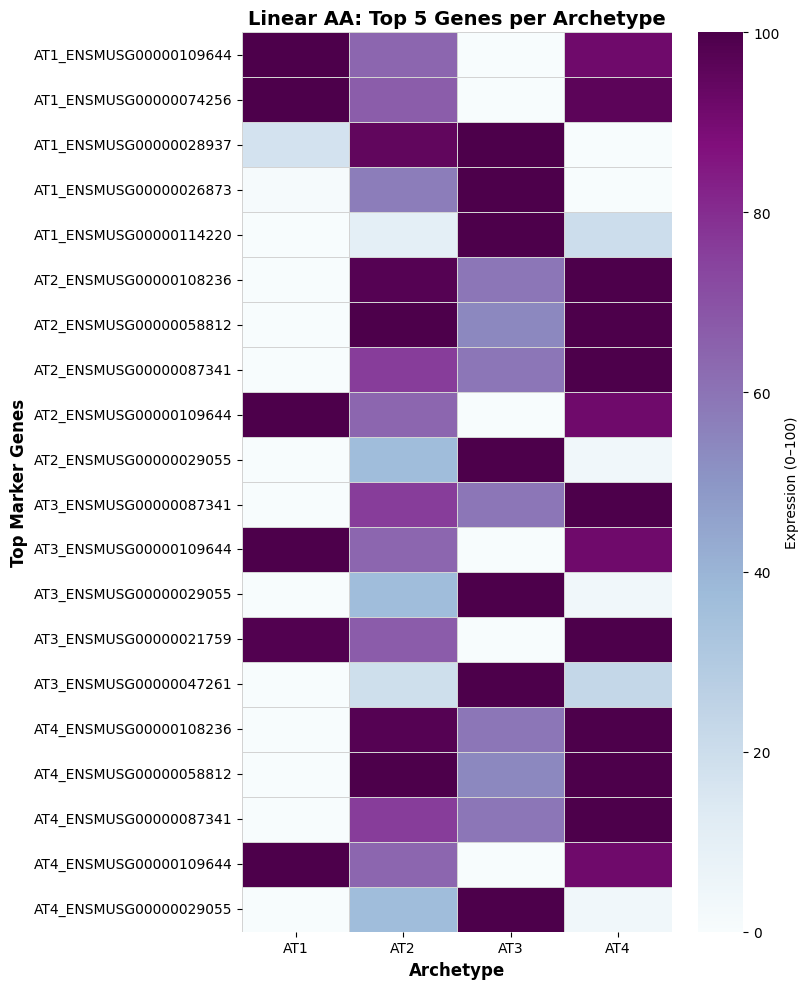


Linear AA - Top genes per archetype:

Archetype 1:
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000074256: 99.9th percentile
  ENSMUSG00000028937: 99.9th percentile
  ENSMUSG00000026873: 99.9th percentile
  ENSMUSG00000114220: 99.9th percentile

Archetype 2:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000058812: 100.0th percentile
  ENSMUSG00000087341: 100.0th percentile
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000029055: 99.9th percentile

Archetype 3:
  ENSMUSG00000087341: 100.0th percentile
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000029055: 99.9th percentile
  ENSMUSG00000021759: 99.9th percentile
  ENSMUSG00000047261: 99.9th percentile

Archetype 4:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000058812: 100.0th percentile
  ENSMUSG00000087341: 100.0th percentile
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000029055: 99.9th percentile


In [60]:

# =============================================================================
# VISUALIZATIONS FOR LINEAR AA (0–100 SCALE)
# =============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load full dataset for gene names
adata_beta_hfd_full = sc.read_h5ad('data/beta_cells_hfd.h5ad')
gene_names = adata_beta_hfd_full.var_names.tolist()

# Get full data
if hasattr(adata_beta_hfd_full.X, 'toarray'):
    X_full = adata_beta_hfd_full.X.toarray()
else:
    X_full = adata_beta_hfd_full.X

# --- FIGURE: Top genes per archetype (Linear AA, 0–100 scale) ---
top_k = 5
all_top_genes = []
heatmap_data = []

for i in range(N_ARCHETYPES):
    archetype_expr = data_ats_linear[i, :]
    
    # Calculate percentiles (using only the 1000 subsampled cells you trained on)
    X_subset = X_full[:1000, :]
    percentiles = np.array([(X_subset[:, j] < archetype_expr[j]).sum() / len(X_subset) * 100 
                            for j in range(len(archetype_expr))])
    
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    
    for idx in top_indices:
        gene = gene_names[idx]
        all_top_genes.append(f"AT{i+1}_{gene}")
        expr_values = [data_ats_linear[j, idx] for j in range(N_ARCHETYPES)]
        heatmap_data.append(expr_values)

# Create heatmap
heatmap_df = pd.DataFrame(heatmap_data, 
                          index=all_top_genes,
                          columns=[f'AT{i+1}' for i in range(N_ARCHETYPES)])

# Normalize per gene to 0–100
heatmap_df_norm = (heatmap_df - heatmap_df.min(axis=1).values[:, None]) / \
                  (heatmap_df.max(axis=1) - heatmap_df.min(axis=1)).values[:, None] * 100

# CLEAN GENE NAMES FOR BETTER VISUALIZATION
# REMOVE "ESNMUSG000000"
def clean_gene_name(name):
    return name.replace("ENSMUSG000000", "")

# plot with the cleaned gene names

fig, ax = plt.subplots(figsize=(8, max(10, top_k * N_ARCHETYPES * 0.4)))
sns.heatmap(heatmap_df_norm, cmap='BuPu', 
            cbar_kws={'label': 'Expression (0–100)'},
            linewidths=0.5, linecolor='lightgray',
            ax=ax, vmin=0, vmax=100, yticklabels=True)

ax.set_xlabel('Archetype', fontsize=12, fontweight='bold')
ax.set_ylabel('Top Marker Genes', fontsize=12, fontweight='bold')
ax.set_title(f'Linear AA: Top {top_k} Genes per Archetype', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig(f'{SAVE_DIR}/linear_aa_gene_signatures_0_100.png', dpi=300, bbox_inches='tight')
plt.close()

# Print top genes per archetype
print("\nLinear AA - Top genes per archetype:")
for i in range(N_ARCHETYPES):
    archetype_expr = data_ats_linear[i, :]
    X_subset = X_full[:1000, :]
    percentiles = np.array([(X_subset[:, j] < archetype_expr[j]).sum() / len(X_subset) * 100 
                            for j in range(len(archetype_expr))])
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    
    print(f"\nArchetype {i+1}:")
    for idx in top_indices:
        gene = gene_names[idx]
        print(f"  {gene}: {percentiles[idx]:.1f}th percentile")


Calculating PHATE...
  Running PHATE on 1000 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.24 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.99 seconds.
Calculated PHATE in 1.59 seconds.


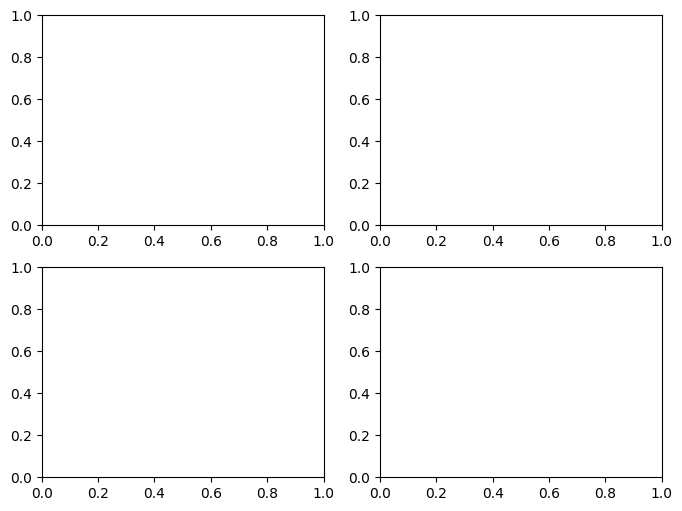

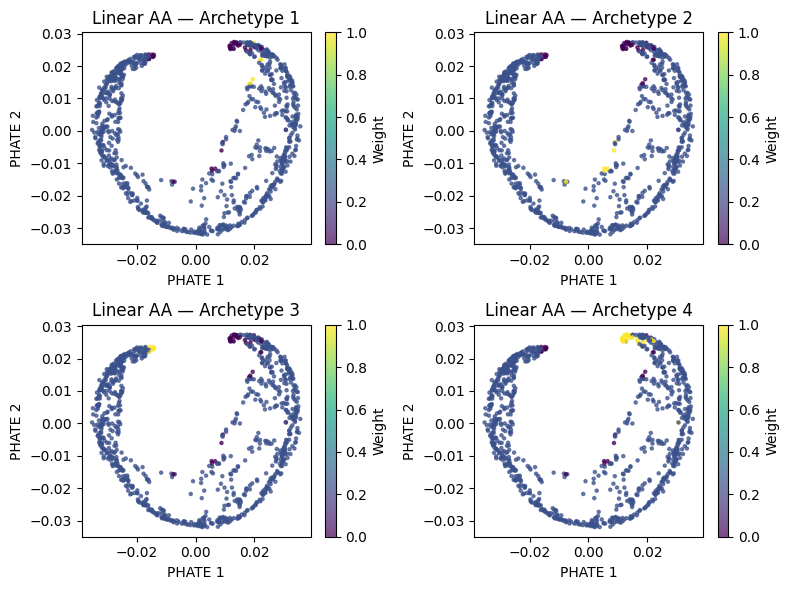

<Figure size 640x480 with 0 Axes>

In [67]:
import phate

# Compute PHATE embedding on your 1000 × genes or 1000 × PCs dataset
phate_op = phate.PHATE(random_state=42)
data_phate_linear = phate_op.fit_transform(X_pca)  # or hfd_magic_pc_norm

# Plot archetype weights
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()


fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i in range(N_ARCHETYPES):
    ax = axes[i]
    sc = ax.scatter(data_phate_linear[:, 0], data_phate_linear[:, 1],
                    c=barycentric_embedding_linear[:, i],
                    cmap='viridis', s=5, alpha=0.7,
                    vmin=0, vmax=1)  # ← ADD THIS
    ax.set_title(f'Linear AA — Archetype {i+1}')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    plt.colorbar(sc, ax=ax, label='Weight')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'phate_archetypes_linear.png'), dpi=300)
plt.show()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'phate_archetypes_linear.png'), dpi=300)
plt.show()





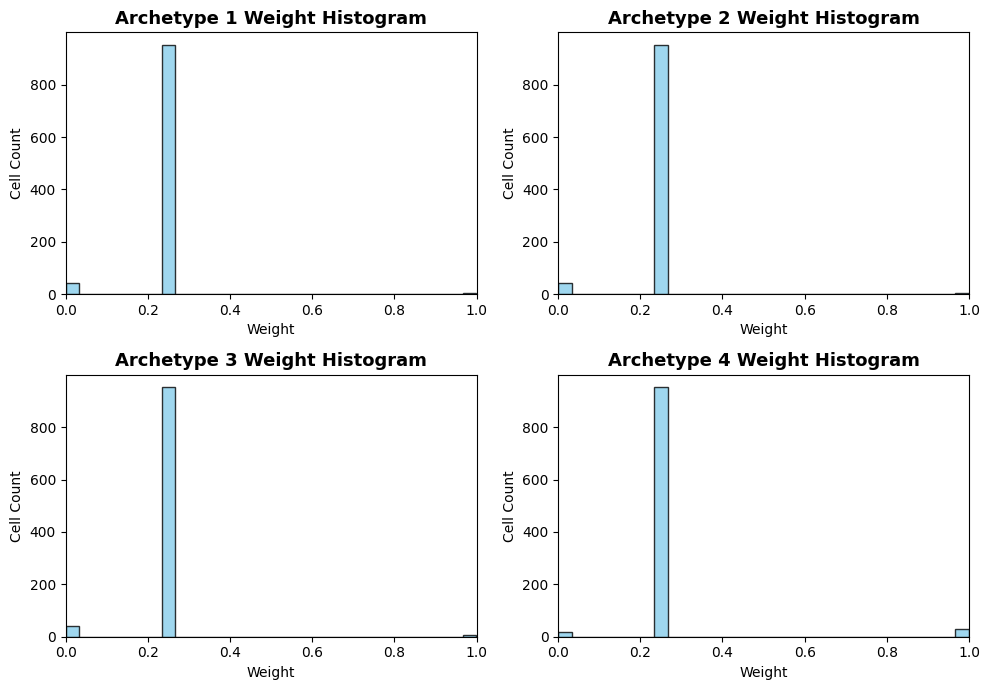

✓ Saved archetype weight histograms


<Figure size 640x480 with 0 Axes>

In [66]:

# Plot histogram of archetype weights for each archetype
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()
for i in range(N_ARCHETYPES):
    ax = axes[i]
    ax.hist(barycentric_embedding_linear[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.8)
    ax.set_title(f'Archetype {i+1} Weight Histogram', fontsize=13, fontweight='bold')
    ax.set_xlabel('Weight')
    ax.set_ylabel('Cell Count')
    ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(SAVE_DIR, 'archetype_weight_histograms.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved archetype weight histograms")


In [62]:
# Add this diagnostic code after running Linear AA:
C_linear_best = C_list[best_run_idx]

print("\n=== Linear AA Weight Distribution ===")
print(f"Min weight: {C_linear_best.min():.6f}")
print(f"Max weight: {C_linear_best.max():.6f}")
print(f"Mean weight: {C_linear_best.mean():.6f}")
print(f"Median weight: {C_linear_best.median():.6f}")

# Check sparsity
near_zero = (C_linear_best < 0.01).sum()
near_one = (C_linear_best > 0.99).sum()
intermediate = ((C_linear_best >= 0.01) & (C_linear_best <= 0.99)).sum()

total = C_linear_best.numel()
print(f"\nSparsity analysis:")
print(f"  Near 0 (<0.01): {near_zero}/{total} ({100*near_zero/total:.1f}%)")
print(f"  Near 1 (>0.99): {near_one}/{total} ({100*near_one/total:.1f}%)")
print(f"  Intermediate (0.01-0.99): {intermediate}/{total} ({100*intermediate/total:.1f}%)")

# Look at some example cells
print(f"\nExample cell weights (first 5 cells):")
for i in range(5):
    weights = C_linear_best[i, :]
    print(f"  Cell {i}: {weights}")


=== Linear AA Weight Distribution ===
Min weight: -0.000000
Max weight: 0.432366
Mean weight: 0.001000


AttributeError: 'numpy.ndarray' object has no attribute 'median'